# Health Care - Malaria

In [76]:
# importing the required libraries and reading the data
import pandas as pd 

data = pd.read_csv("Malaria.csv")

In [77]:
data

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,MALARIA_EST_INCIDENCE,Estimated malaria incidence (per 1000 populati...,text,AFR,Africa,Country,DZA,Algeria,Year,2022,...,NaN,NaN,0.00,NaN,0.00,0 [0-0],NaN,NaN,EN,2024-03-08T07:00:00.000Z
1,MALARIA_EST_INCIDENCE,Estimated malaria incidence (per 1000 populati...,text,AMR,Americas,Country,ARG,Argentina,Year,2022,...,NaN,NaN,0.00,NaN,0.00,0 [0-0],NaN,NaN,EN,2024-03-08T07:00:00.000Z
2,MALARIA_EST_INCIDENCE,Estimated malaria incidence (per 1000 populati...,text,EUR,Europe,Country,ARM,Armenia,Year,2022,...,NaN,NaN,0.00,NaN,0.00,0 [0-0],NaN,NaN,EN,2024-03-08T07:00:00.000Z
3,MALARIA_EST_INCIDENCE,Estimated malaria incidence (per 1000 populati...,text,EUR,Europe,Country,AZE,Azerbaijan,Year,2022,...,NaN,NaN,0.00,NaN,0.00,0 [0-0],NaN,NaN,EN,2024-03-08T07:00:00.000Z
4,MALARIA_EST_INCIDENCE,Estimated malaria incidence (per 1000 populati...,text,AMR,Americas,Country,BLZ,Belize,Year,2022,...,NaN,NaN,0.00,NaN,0.00,0 [0-0],NaN,NaN,EN,2024-03-08T07:00:00.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2502,MALARIA_EST_INCIDENCE,Estimated malaria incidence (per 1000 populati...,text,AMR,Americas,Country,PER,Peru,Year,2000,...,NaN,NaN,6.92,NaN,11.15,9.00 [6.92-11.15],NaN,NaN,EN,2024-03-08T07:00:00.000Z
2503,MALARIA_EST_INCIDENCE,Estimated malaria incidence (per 1000 populati...,text,EUR,Europe,Country,TJK,Tajikistan,Year,2000,...,NaN,NaN,9.10,NaN,9.10,9.10 [9.10-9.10],NaN,NaN,EN,2024-03-08T07:00:00.000Z
2504,MALARIA_EST_INCIDENCE,Estimated malaria incidence (per 1000 populati...,text,AMR,Americas,Country,HTI,Haiti,Year,2000,...,NaN,NaN,5.58,NaN,15.54,9.67 [5.58-15.54],NaN,NaN,EN,2024-03-08T07:00:00.000Z
2505,MALARIA_EST_INCIDENCE,Estimated malaria incidence (per 1000 populati...,text,SEAR,South-East Asia,Country,PRK,Democratic People's Republic of Korea,Year,2000,...,NaN,NaN,9.92,NaN,9.92,9.92 [9.92-9.92],NaN,NaN,EN,2024-03-08T07:00:00.000Z


In [78]:
# removing the columns which have all null values
data.dropna(axis=1, how='all', inplace=True)

In [79]:
# removing the Value column which is not our outcome of intrest
data=data.drop(columns = ["Value"])

In [80]:
# using simple imputer from scikit-learn to handle the missing values
from sklearn.impute import SimpleImputer

categorical_cols = data.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = data.select_dtypes(include=["number"]).columns.tolist()

# Replacing the null values in numerical columns with mean
imputer_numerical = SimpleImputer(strategy='mean')
data[numerical_cols] = imputer_numerical.fit_transform(data[numerical_cols])

# Replacing the null values in categorical columns with most-frequent item in the feature
imputer_categorical = SimpleImputer(strategy='most_frequent')
data[categorical_cols] = imputer_categorical.fit_transform(data[categorical_cols])

# Data Visualization

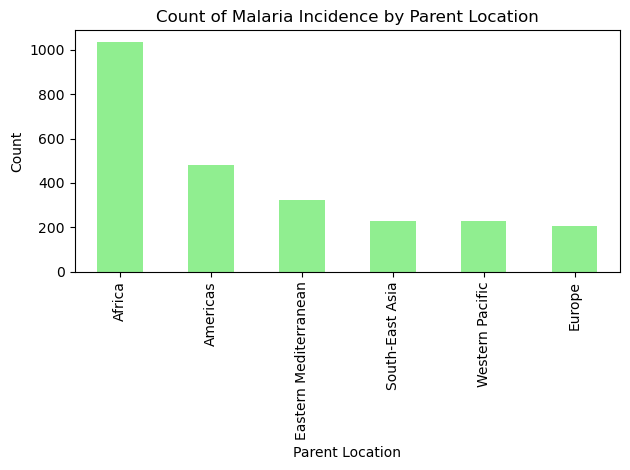

In [81]:
import matplotlib.pyplot as plt
data['ParentLocation'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Count of Malaria Incidence by Parent Location')
plt.xlabel('Parent Location')
plt.ylabel('Count')
plt.savefig("Count of Malaria Incidence by Location.png",dpi=72)
plt.tight_layout()
plt.show()


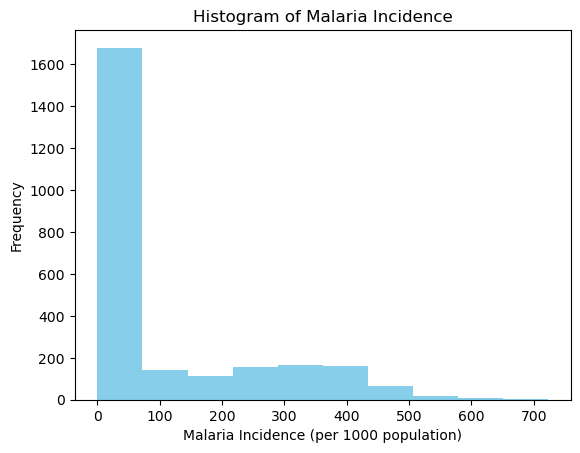

In [82]:
plt.hist(data["FactValueNumeric"], bins=10, color='skyblue')
plt.title('Histogram of Malaria Incidence')
plt.xlabel('Malaria Incidence (per 1000 population)')
plt.ylabel('Frequency')
plt.savefig("Count of Malaria Incidence.png",dpi=72)
plt.show()

In [83]:
from sklearn.preprocessing import LabelEncoder
Le = LabelEncoder()

for column in categorical_cols:
    data[column] = Le.fit_transform(data[column])

In [84]:
# Applying the standardization to the numerical features such that all the features will be on same scale which is required for the model to perform analysis effectively
from sklearn.preprocessing import StandardScaler

standardscaler = StandardScaler()

data[['Period']] = standardscaler.fit_transform(data[['Period']])
data[['FactValueNumeric']] = standardscaler.fit_transform(data[['FactValueNumeric']])
data[['FactFactValueNumericLow']] = standardscaler.fit_transform(data[['FactValueNumericLow']])
data[['FactValueNumericHigh']] = standardscaler.fit_transform(data[['FactValueNumericHigh']])

mean = standardscaler.mean_[0]
std = standardscaler.scale_[0]

In [85]:
# Identifying the outliers using IQR and removing them
Q1 = data['FactValueNumeric'].quantile(0.25)
Q3 = data['FactValueNumeric'].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers
data = data[(data['FactValueNumeric'] >= (Q1 - 1.5 * IQR)) & (data['FactValueNumeric'] <= (Q3 + 1.5 * IQR))]


In [86]:
# Moving the Valuenumeric to last column as this is our outcome of intrest
column_to_move = "FactValueNumeric"
data = data[[col for col in data.columns if col != column_to_move] + [column_to_move]]

X = data.iloc[:,:-1]
Y = data.iloc[:,-1]

In [87]:
# using the random forest regressor to get the important features thus reducing dimensionality
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X, Y)
importances = model.feature_importances_


In [88]:
# Slicing the data with important features
important_indices = [i for i in range(len(importances)) if importances[i] > pd.Series(importances).quantile(0.50)]

important_features = X.iloc[:, important_indices]


In [89]:
important_features=important_features.rename(columns = {"Period":"Year"})

In [90]:
# Visualizing the data after preprocessing
important_features

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Year,FactValueNumericLow,FactValueNumericHigh,FactFactValueNumericLow
0,0,0,27,1,1.658312,0.00,-0.693071,-0.649842
1,1,1,3,3,1.658312,0.00,-0.693071,-0.649842
2,3,3,4,4,1.658312,0.00,-0.693071,-0.649842
3,3,3,5,5,1.658312,0.00,-0.693071,-0.649842
4,1,1,10,7,1.658312,0.00,-0.693071,-0.649842
...,...,...,...,...,...,...,...,...
2502,1,1,74,77,-1.658312,6.92,-0.638141,-0.587085
2503,3,3,95,93,-1.658312,9.10,-0.648240,-0.567315
2504,1,1,43,46,-1.658312,5.58,-0.616513,-0.599238
2505,4,4,77,26,-1.658312,9.92,-0.644200,-0.559878
